In [1]:
%matplotlib inline
from utils import read, createGraph, readGenders, readGenre
from glob import iglob as glob
from os.path import exists, basename
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
import numpy as np
import scipy as sp
import pickle
import warnings
import community
import networkx as nx
import itertools
import scipy as sp 
import logging
from funcy import walk_values

plt.rcParams["figure.figsize"] = (10, 8)

In [2]:
logging.basicConfig(format = "%(asctime)-15s %(message)s", level = logging.DEBUG)

In [3]:
th = 2
data_dir = "../data/utterances_with_charnames/*"
info_dir = "../data/charandmovie_info/"

## Read all scripts

In [4]:
data = {}
for script in glob(data_dir):
    
    gens, races, genres = None, None, None
    _, char_list, adj = read(script, threshold = th)

    extra_info = info_dir + basename(script)
    if exists(extra_info):
        gens, races = readGenders(extra_info)
        genres = readGenre(extra_info)
    else:
#         logging.warning("Info for {} not found".format(basename(script)))
#         gens = defaultdict(lambda: 'unknown')
#         races = defaultdict(lambda: 'unknown')  
        continue
        
    races = walk_values(lambda x: x.split(",")[0], races)
        
    G = createGraph(char_list, adj, gens, races)

    

    key = basename(script)

    data[key] = {}
    data[key]['graph'] = G
    data[key]['chars'] = char_list
    data[key]['genres'] = genres
    data[key]['races'] = races
    

In [5]:
data['american_beauty.txt']

{'chars': array(['ANGELA', 'BARBARA', 'BUDDY', 'CAROLYN', 'COLONEL', 'CONTINUED',
        'JANE', 'JIM #1', 'JIM #2', 'LESTER', 'RICKY', 'TAPE VOICE'], 
       dtype='<U15'),
 'genres': ['Drama', 'Romance'],
 'graph': <networkx.classes.graph.Graph at 0x10e7d1320>,
 'races': defaultdict(<function funcy.funcs.compose.<locals>.<lambda>.<locals>.<lambda>>,
             {'ANGELA': 'caucasian',
              'BARBARA': 'caucasian',
              'BRAD': 'caucasian',
              'BUDDY': 'caucasian',
              'CAROLYN': 'caucasian',
              'COLONEL': 'caucasian',
              'CONTINUED': 'unknown',
              'JANE': 'caucasian',
              'JIM #1': 'unknown',
              'JIM #2': 'unknown',
              'JIM 1': 'caucasian',
              'JIM 2': 'caucasian',
              'LESTER': 'caucasian',
              'RICKY': 'caucasian',
              'TAPE VOICE': 'unknown'})}

In [6]:
np.sum([nx.number_of_nodes(d['graph']) for d in data.values()])

15133

In [7]:
types = Counter([y for x in [d['genres'] for script, d in data.items()] for y in x])
print(types)
types = list(types.keys())

Counter({'Drama': 559, 'Thriller': 368, 'Comedy': 287, 'Action': 252, 'Crime': 242, 'Romance': 194, 'Adventure': 170, 'Sci-Fi': 156, 'Mystery': 145, 'Horror': 116, 'Fantasy': 115, 'Biography': 70, 'Family': 49, 'History': 34, 'War': 34, 'Animation': 32, 'Sport': 32, 'Music': 22, 'Musical': 19, 'Western': 17, 'Short': 5, 'Film-Noir': 5})


In [8]:
races = Counter([y for x in [list(d['races'].values()) for d in data.values()] for y in x])
print(races)
races = list(races.keys())

Counter({'caucasian': 8219, 'unknown': 6750, 'african': 881, 'latino': 281, 'other': 234, 'eastasian': 137, 'nativeamerican': 77, 'asianindian': 77, 'pacificislander': 22, 'others': 12})


In [9]:
xkcd_colors = sns.xkcd_palette(["grass green", "sand", "blue", "light red", "cerulean",
                                "red", "light blue", "teal", "orange", "light green",
                                "magenta", "yellow", "sky blue", "grey", "cobalt",
                                "grass", "algae green", "coral", "cerise", "steel",
                                "hot purple", "mango", "pale lime", "rouge"])
colors = itertools.cycle(xkcd_colors)

# Pre-check
In [GENDER BIAS WITHOUT BORDERS](http://seejane.org/wp-content/uploads/gender-bias-without-borders-executive-summary.pdf), there is a ratio of 2.25 men for every women on screen (women = $30.9$%). Lets check our numbers.

In [ ]:
total, males, females = 0, 0, 0
for _, d in data.items():
    G = d['graph']
    
    for i in G.nodes():
        if G.node[i]['gender'] == 'male':
            males += 1
        elif G.node[i]['gender'] == 'female':
            females += 1
        
        total += 1
        
print("total: {}".format(total))
print("males: {:.2f}%".format(float(males) / total))
print("females: {:.2f}%".format(float(females) / total))


What if we drop unknown?... shouldn't matter right?

In [ ]:
print("males: {:.2f}%".format(float(males) / (males + females)))
print("females: {:.2f}%".format(float(females) / (males + females)))

# Graph analysis

# Degree centrality

#### Average degree

In [ ]:
warnings.simplefilter("ignore")
male_deg, female_deg = [], []
for script, d in data.items():
    G = d['graph']
    degrees = nx.degree(G)
    
    male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

In [ ]:
#Remove nans

male_deg = np.array(male_deg)
female_deg = np.array(female_deg)

male_deg = male_deg[~np.isnan(male_deg)]
female_deg = female_deg[~np.isnan(female_deg)]

In [ ]:
sp.stats.describe([y for x in [list(nx.degree(d['graph']).values()) for script, d in data.items()]
     for y in x])

In [ ]:
sns.distplot(male_deg, hist = False, label = "male");
sns.distplot(female_deg, hist = False, label = "female");
plt.legend();
plt.xlabel("average degree");

There is no real difference in the number of connections between men and women.

In [ ]:
sp.stats.ttest_ind(male_deg, female_deg)

### Based on Genre

In [ ]:
res = {}
for t in types:
    male_deg, female_deg = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        degrees = nx.degree(G)

        male_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_deg.append(np.mean([degrees[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_deg
    res[t]['female'] = female_deg

In [ ]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

In [ ]:
g = sns.FacetGrid(tmp, col = "genre", row = "gender")
g = g.map(sns.distplot, "value", hist=False)

In [ ]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__There are no significant differences between the degrees based on gender.__

In [ ]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]


# Betweeness Centrality

#### Average centrality

In [10]:
male_cent, female_cent = [], []
for script, d in data.items():
    G = d['graph']
    cents = nx.betweenness_centrality(G)
    
    male_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
    female_cent.append(np.mean([cents[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))

/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [11]:
#Remove nans
male_cent, female_cent = np.array(male_cent), np.array(female_cent)
male_cent = male_cent[~np.isnan(male_cent)]
female_cent = female_cent[~np.isnan(female_cent)]

In [12]:
sp.stats.describe([y for x in [list(nx.betweenness_centrality(d['graph']).values()) for d in data.values()] for y in x])

DescribeResult(nobs=15133, minmax=(0.0, 1.0), mean=0.045594842347982223, variance=0.008703655574351616, skewness=3.556193182203275, kurtosis=15.501383735343609)

Just a quick note, this is a _density_, not a probability. The AUC adds up to 1. 

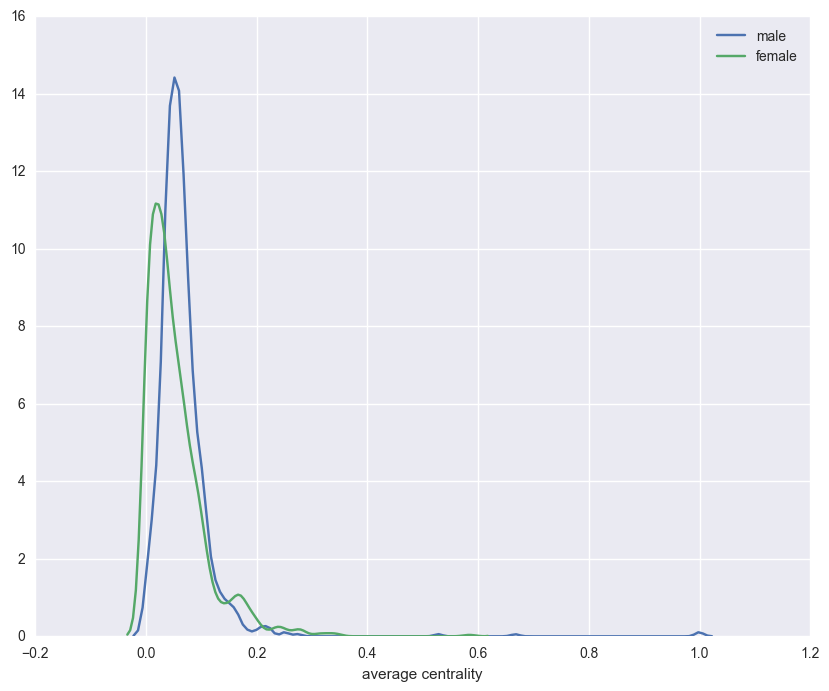

In [13]:
sns.distplot(male_cent, hist = False, label = "male");
sns.distplot(female_cent, hist = False, label = "female");
plt.legend();
plt.xlabel("average centrality");

In this case, there is a significant difference in the average centrality of male characters and female characters ($t(?) = 4.8805,\, p < 0.01$). In most of the scripts, males occupy a more central role than females.

In [ ]:
sp.stats.ttest_ind(male_cent, female_cent)

## By Genre

In [14]:
res = {}
for t in types:
    male_centr, female_centr = [], []
    for script, d in data.items():
        
        if t not in d['genres']:
            continue 
            
        G = d['graph']
        centralities = nx.betweenness_centrality(G)

        male_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'male']))
        female_centr.append(np.mean([centralities[i] for i in G.nodes() if G.node[i]['gender'] == 'female']))
    
    res[t] = {}
    res[t]['male'] = male_centr
    res[t]['female'] = female_centr

/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/Users/victor/miniconda3/lib/python3.5/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [15]:
# Pass into long format
tmp = []
for t, k in res.items():
    for g, v in k.items():
        for i in v:
            tmp.append((t, g, i))

tmp = pd.DataFrame(tmp, columns=["genre", "gender", "value"])

#Drop nan's
tmp = tmp[(tmp.genre!="Documentary")]
tmp = tmp[(tmp.genre!="Short")]
tmp = tmp[(tmp.genre!="Reality-TV")]

tmp.head()

,genre,gender,value
0,Comedy,female,0.030474
1,Comedy,female,0.051921
2,Comedy,female,0.056481
3,Comedy,female,0.052525
4,Comedy,female,0.088974


In [17]:
res = {}
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"]
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"]
    
    #Remove nans
    male_deg, female_deg = np.array(male_deg), np.array(female_deg)
    male_deg = male_deg[~np.isnan(male_deg)]
    female_deg = female_deg[~np.isnan(female_deg)]

    ttest = sp.stats.ttest_ind(male_deg, female_deg)

    if not np.isnan(ttest.pvalue):
        res[t] = ttest
    
res;

__ There is a real difference in the centrality of characters in: __

In [18]:
# Using Benjamin-Hochberg's method
res_2 = sorted(res.items(), key = lambda x: x[1].pvalue)
m = len(res_2)

i = 1
while i < len(res_2) + 1:
    if res_2[i - 1][1].pvalue > i / m * 0.05:
        break
    i = i + 1
        
res_2[:(i - 1)]

[('Drama',
  Ttest_indResult(statistic=5.5262644731199071, pvalue=4.0836730069907744e-08)),
 ('Comedy',
  Ttest_indResult(statistic=4.9098226229261925, pvalue=1.1971133888063754e-06)),
 ('Horror',
  Ttest_indResult(statistic=-4.4777638911415742, pvalue=1.1923689840356018e-05)),
 ('Sport',
  Ttest_indResult(statistic=4.308836031933156, pvalue=6.0748376366828641e-05)),
 ('Biography',
  Ttest_indResult(statistic=3.1693058305550705, pvalue=0.0018850415732367494)),
 ('Sci-Fi',
  Ttest_indResult(statistic=2.5448253204036693, pvalue=0.011427429949245071))]

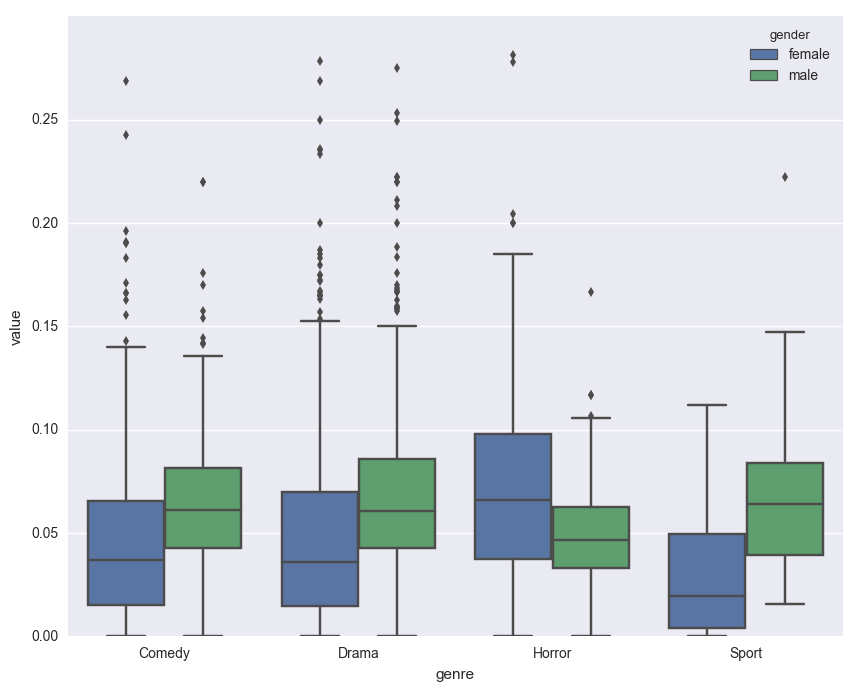

In [27]:
t = tmp[tmp.genre.isin(['Drama', 'Comedy', 'Horror', 'Sport'])]
bplt = sns.boxplot(x = 'genre', y = 'value', hue = 'gender', data = t)
bplt.axes.set_ylim([0, .3]);

In [ ]:
for t in types:
    male_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "male"), "value"].mean()
    female_deg = tmp.ix[(tmp.genre == t) & (tmp.gender == "female"), "value"].mean()

    
    if male_deg < female_deg:
        print(t, male_deg, female_deg)
    

## By Race

I can either agg by race (e.g., caucassian males get more important roles) or I could agg races by gender (e.g., latino women are more demanded than latino men).

In [ ]:
# Agg by race

aggByRace = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByRace.append((G.node[n]['race'], centrs[n]))
        
aggByRace = pd.DataFrame(aggByRace, columns=['race', 'value'])
aggByRace = aggByRace[aggByRace.race != 'unknown']
aggByRace.head()

In [ ]:
sns.boxplot(x = "race", y = "value", hue = "race", data = aggByRace);

In [ ]:
#1-way ANOVA for differences

import statsmodels.api as sm
from statsmodels.formula.api import ols

mod = ols('value ~ race',
                data=aggByRace).fit()
                
aov_table = sm.stats.anova_lm(mod, typ=2)
print(aov_table)

Post-hoc: Find differences by comparing each two and controlling error with Benjamin-Hochberg's method

__TODO:__ But this doesnt matter too much

### Agg race and gender

In [25]:
# Agg by race & gender

aggByRaceGender = []

for script, d in data.items():
    G = d['graph']
    centrs = nx.betweenness_centrality(G)
    
    
    for n in G.nodes():
        aggByRaceGender.append((G.node[n]['race'], G.node[n]['gender'], centrs[n]))
        
aggByRaceGender = pd.DataFrame(aggByRaceGender, columns=['race', 'gender', 'value'])
aggByRaceGender = aggByRaceGender[aggByRaceGender.race != 'unknown']
aggByRaceGender = aggByRaceGender[aggByRaceGender.gender != 'unknown']

aggByRaceGender.head()

,race,gender,value
1,caucasian,male,0.007407
2,caucasian,female,0.000000
3,caucasian,male,0.098148
4,caucasian,female,0.114815
6,caucasian,male,0.018519


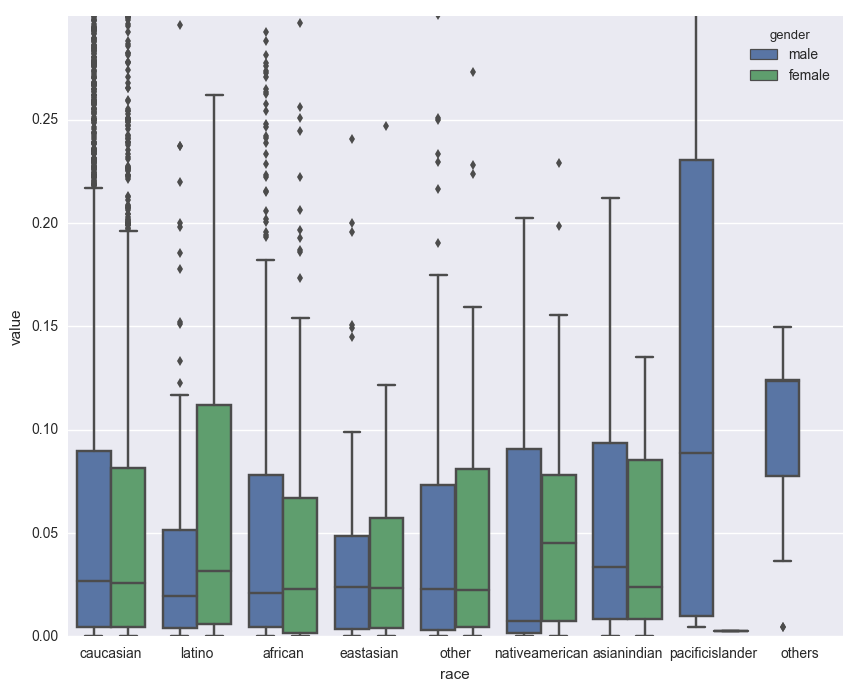

In [28]:
bxplt = sns.boxplot(x = "race", y = "value", hue = "gender", data = aggByRaceGender);
bxplt.axes.set_ylim([0, .3]);

## Communities and Modularities

Extract the community structure and modularity measurement of each graph using Louvain Method. The Louvain Method was created by Blondel et. al [https://arxiv.org/abs/0803.0476]

In [ ]:
communities = []
modularities = []

for t in types:
    for script, d in data.items():
        if t not in d['genres']:
            continue
        
        G = d['graph']
        parts = community.best_partition(G)
        try:
            q = community.modularity(parts, G)
        except ValueError:
            logging.debug("Script {} has no links".format(script))
    
        communities.append((t, len(set(parts.values()))))
        modularities.append((t, q))
        
communities = pd.DataFrame(communities, columns=["genre", "communities"])
modularities = pd.DataFrame(modularities, columns=["genre", "modularity"])

In [ ]:
communities.communities.describe()

In [ ]:
communities.groupby("genre").apply(np.mean).sort_values(by="communities")

In [ ]:
axs = sns.boxplot(x = "genre", y = "communities", data = communities, palette=xkcd_colors)
for item in axs.get_xticklabels():
    item.set_rotation(90)

In [ ]:
modularities.modularity.describe()

In [ ]:
modularities.groupby("genre").apply(np.mean).sort_values(by="modularity")

In [ ]:
axs = sns.boxplot(x = "genre", y = "modularity", data = modularities, palette=xkcd_colors)
for item in axs.get_xticklabels():
    item.set_rotation(90)

## Can modularity predict genre?
Baseline: Most popular genre

In [ ]:
from sklearn.preprocessing import MultiLabelBinarizer
Y = MultiLabelBinarizer().fit_transform([d['genres'] for d in data.values()])
Y.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn.multiclass import OneVsRestClassifier

train, test = train_test_split(np.arange(Y.shape[0]), test_size=0.25)

In [ ]:
mod_baseline = OneVsRestClassifier(LogisticRegression())
mod_baseline.fit(np.ones_like(Y[train, :]), Y[train, :])

pred_baseline = mod.predict(np.ones_like(Y[test, :]))
pred_baseline